# Example notebook for classification analysis

This notebook contains an example analysis of WatChMaL classification runs, including comparison to fiTQun reconstruction.

Plots are included of the training progression, ROC curves, and various plots of signal or background efficiency vs physical quantities.

## Imports and setup

First change some display settings for the notebook

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("<style>div.output_scroll { height: 44em; }</style>"))

External imports:

In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.optimize as opt
import sys
import h5py
import tabulate

In [4]:
# either add WatChMaL repository directory to PYTHONPATH environment variable or add it here
sys.path.append('/home/nprouse/WatChMaL/WatChMaL')

Import WatChMaL analysis code

In [5]:
import analysis.utils.math as math
from analysis.utils.binning import get_binning, apply_binning
from analysis.utils.plotting import plot_legend
from analysis.classification import WatChMaLClassification, FiTQunClassification, plot_rocs, plot_efficiency_profile
from analysis.read import FiTQunOutput

# Preparing data

In [6]:
# list of particle names to use in filename
particle_names = ['gamma', 'e-', 'mu-', 'pi0'] # note that the order corresponds to labels 0, 1, 2, 3

## Get true particle data from h5 file

In [7]:
# list of particle names to use in filename
particle_names = ['gamma', 'e-', 'mu-', 'pi0'] # note that the order corresponds to labels 0, 1, 2, 3

In [8]:
# get indices of test events
idxs_path = '/fast_scratch/WatChMaL/data/IWCD_mPMT_Short/index_lists/4class_e_mu_gamma_pi0/IWCD_mPMT_Short_4_class_3M_emgp0_idxs.npz'
test_idxs  =  np.load(idxs_path, allow_pickle=True)['test_idxs']

### Open H5 data

In [9]:
# open h5 file and get data for test events
data_path = "/fast_scratch/WatChMaL/data/IWCD_mPMT_Short/IWCD_mPMT_Short_emgp0_E0to1000MeV_digihits.h5"
h5_file = h5py.File(data_path, "r")
h5_angles     = np.array(h5_file['angles'])[test_idxs].squeeze()
h5_energies   = np.array(h5_file['energies'])[test_idxs].squeeze()
h5_positions  = np.array(h5_file['positions'])[test_idxs].squeeze()
h5_labels     = np.array(h5_file['labels'])[test_idxs].squeeze()
h5_root_files = np.array(h5_file['root_files'])[test_idxs].squeeze()
h5_event_ids  = np.array(h5_file['event_ids'])[test_idxs].squeeze()
h5_vetos      = np.array(h5_file['veto'])[test_idxs].squeeze()
events_hits_index = np.append(h5_file['event_hits_index'], h5_file['hit_pmt'].shape[0])
h5_nhits      = (events_hits_index[test_idxs+1] - events_hits_index[test_idxs]).squeeze()

In [10]:
h5_directions = math.direction_from_angles(h5_angles)

## Get fiTQun data from files

In [11]:
# list of particle names to use in filename
particle_names = ['gamma', 'e-', 'mu-', 'pi0'] # note that the order corresponds to labels 0, 1, 2, 3

fiTQun data for the IWCD events is stored in separate files for each particle type. Here we get the set of fiTQun files and open them using the FiTQunOutput class, which provides many useful attributes and methods for accessing fiTQun outputs:

In [12]:
help(FiTQunOutput)

Help on class FiTQunOutput in module analysis.read:

class FiTQunOutput(builtins.object)
 |  FiTQunOutput(file_path)
 |  
 |  Class for reading in results of fiTQun reconstruction. Documentation of the outputs provided is mostly taken
 |  directly from the fiTQun readme file. See github.com/fiTQun/fiTQun (access to private repository required) for more
 |  details.
 |  
 |  Time-window information
 |  -----------------------
 |  The following attributes are provided for the fiTQun outputs of the hit time clustering algorithm:
 |  
 |  ======================================================================================================
 |  Attribute name        fiTQun output     Description
 |  ======================================================================================================
 |  n_timewindows         fqntwnd           Number of time windows (good clusters) in this event
 |  timewindow            fqtwnd            Cluster index of the time window(corresponds to clus

In [13]:
# get the data from the fitqun files
fq_path = "/fast_scratch/WatChMaL/data/IWCD_mPMT_Short/fiTQun/"
particle_order = [particle_names[i] for i in h5_labels[::1200000]] # There's 1,200,000 of each particle type in this test set
fq_files = [fq_path + f"IWCD_mPMT_Short_{p}_E0to1000MeV_unif-pos-R400-y300cm_4pi-dir.fiTQun.root" for p in particle_order]
fq = FiTQunOutput(fq_files)

## Find the fiTQun events corresponding to the test set
For the IWCD mPMT e/mu/gamma/pi0 data, there are events missing from the h5 file (used for training and testing) that are not missing from the fiTQun set, so we need to find how to match them up properly. We use the following to match them up:
- Each event in the h5 file has a `label` (particle type), a `root_file` and a `event_id`
- The events in the h5 file are ordered by `label` then `root_file` then `event_id`
- The fiTQun files have all events for one particle type, ordered by `root_file`, then by `event_id`
- Each `root_file` originally has exactly 3000 events in the fiTQun file
- The `event_id`s in for each root file in the fiTQun file go consecutively from 0 to 2999
- The h5 file has a subset of the events in the fiTQun files, and has at least one event from every `root_file`

So we could loop through the h5 file events, check the `label` to find which particle it is to choose the corresponding fitqun file, check the `root_file`, if it's the same as the previous then we compare to previous `event_id` and if there's a jump then we skip [new `event_id` minus old `event_id`+1] events in the fiTQun files. If it's a new `root_file` then we skip [new `event_id` plus 3000 minus old `event_id`+1].

Or, we do it more efficiently by adding up index offsets by particle type, root file and event_id, because we know:
- There are 400 `root_files` included in the test set for each particle
- There are 3000 `event_id`s running from 0 to 2999 for each `root_file`

So, if we index the `root_files` from 0 to 399 for particle 0, 400 to 799 for particle 1, and so on, then the offset is just `3000*[root_file_index] + [event_id]`

In [14]:
# create dictionary with keys of the unique root_files
root_file_index = dict.fromkeys(h5_root_files)

In [15]:
# update the values so each root file key has a value from 0 to the number of files
root_file_index.update((k, i) for i, k in enumerate(root_file_index))

In [16]:
# create array of root_file_indices of each event in the h5_root_files array
root_file_indices = np.vectorize(root_file_index.__getitem__)(h5_root_files)
# create the array of offsets from the root_file_indices and the h5_event_ids
h5_fq_offsets = 3000*root_file_indices + h5_event_ids

In [17]:
# Get the fiTQun outputs corresponding to the h5 file's events
h5_flag_e = np.array(fq.electron_flag[h5_fq_offsets])
h5_flag_mu = np.array(fq.muon_flag[h5_fq_offsets])
h5_reco_mom_e = np.array(fq.electron_momentum[h5_fq_offsets])
h5_reco_mom_mu = np.array(fq.muon_momentum[h5_fq_offsets])
h5_reco_mom_pi0 = np.array(fq.pi0_momentum[h5_fq_offsets])

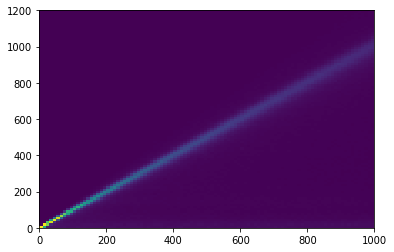

In [18]:
# check gammas seem to be matched right
p = plt.hist2d(h5_energies[h5_labels==0], h5_reco_mom_e[h5_labels==0], bins=100, range=[[0,1000],[0,1200]])

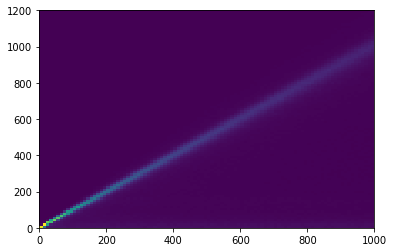

In [19]:
# check electrons seem to be matched right
p = plt.hist2d(h5_energies[h5_labels==1], h5_reco_mom_e[h5_labels==1], bins=100, range=[[0,1000],[0,1200]])

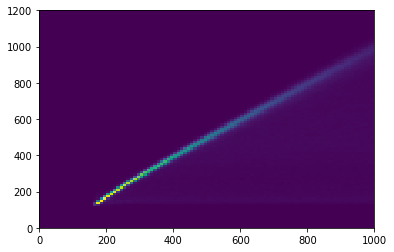

In [20]:
# check muons seem to be matched right
p = plt.hist2d(h5_energies[h5_labels==2], h5_reco_mom_mu[h5_labels==2], bins=100, range=[[0,1000],[0,1200]])

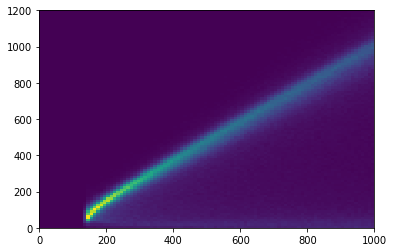

In [21]:
# check pi0s seem to be matched right
p = plt.hist2d(h5_energies[h5_labels==3], h5_reco_mom_pi0[h5_labels==3], bins=100, range=[[0,1000],[0,1200]])

# Plotting fiTQun and ResNet performance

## Set up plotting style

In [22]:
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 28}
matplotlib.rc('font', **font)
matplotlib.rcParams['figure.figsize'] = (12, 9)
matplotlib.rcParams["figure.autolayout"] = True

## Make some cuts to select the events of interest

In [23]:
h5_towall = math.towall(h5_positions, h5_angles)
h5_dwall = math.dwall(h5_positions)
h5_momentum = math.momentum_from_energy(h5_energies, h5_labels)

reco_cut = (h5_flag_e == 0) & (h5_flag_mu == 0)
od_veto_cut = (h5_vetos == 0)
electron_containment_cut = ((h5_towall/100) > (0.63*np.log(h5_momentum) - 2)) | ~np.in1d(h5_labels, [0,1]) # only for electrons or gammas
dwall_cut = h5_dwall > 50
towall_cut = h5_towall > 200
nhit_cut = h5_nhits > 25

h5_gammas = (h5_labels==0)
h5_electrons = (h5_labels==1)
h5_muons = (h5_labels==2)

# select the true electron and muon events that pass the cuts
basic_cuts = ((h5_electrons | h5_muons)
              & od_veto_cut
              & nhit_cut
             )
all_cuts = (basic_cuts
            & electron_containment_cut
            & reco_cut
            & dwall_cut
#             & towall_cut
            )

eg_basic_cuts = ((h5_electrons | h5_gammas)
              & od_veto_cut
              & nhit_cut
             )
eg_all_cuts = (eg_basic_cuts
            & electron_containment_cut
            & reco_cut
            & dwall_cut
#             & towall_cut
            )

## Bin events in various quantities

Here we use the binning functions that allow us to bin events by various quantities:

In [24]:
help(get_binning)

Help on function get_binning in module analysis.utils.binning:

get_binning(x, bins=None, minimum=None, maximum=None, width=None)
    Finds the indices of the bins to which each value in input array belongs, for a set of bins specified either as an
    array of bin edges, number of bins or bin width
    
    Parameters
    ----------
    x: array_like
        Input array to be binned.
    bins: array_like, optional
        If `bins` is an int, it defines the number of equal-width bins in the range (200, by default). If `bins` is an
        array, it is the array of bin edges and must be 1-dimensional and monotonic.
    minimum: int or real, optional
        Lowest bin lower edge (by default use minimum value in `x`). Not used if `bins` is an ndarray of bin edges.
    maximum: int or real, optional
        Highest bin upper edge (by default use minimum value in `x`). Not used if `bins` is an ndarray of bin edges.
    width: int or real, optional
        Width of bins to generate equal w

In [25]:
mom_binning = get_binning(h5_momentum, 20, 0, 1000)
mom_binning_mu = get_binning(h5_momentum, 17, 150, 1000)
reco_mom_e_binning = get_binning(h5_reco_mom_e, 20, 0, 1000)
cos_zenith_binning = get_binning(np.cos(h5_angles[:,0]), 20, -1, 1)
azimuth_binning = get_binning(h5_angles[:,1]*180/np.pi, 20, -180, 180)
dwall_binning = get_binning(h5_dwall, 22, 50, 300)
towall_binning = get_binning(h5_towall, 30, 50, 800)

## Set up plotting style

In [26]:
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 28}
matplotlib.rc('font', **font)
matplotlib.rcParams['figure.figsize'] = (12, 9)
matplotlib.rcParams["figure.autolayout"] = True

# Electron vs muon

## Load results
### Load ResNet and fiTQun results

Here we set up instances of the two classification classes, for WatChMaL and fiTQun outputs:

In [27]:
help(WatChMaLClassification)
help(FiTQunClassification)

Help on class WatChMaLClassification in module analysis.classification:

class WatChMaLClassification(ClassificationRun, analysis.read.WatChMaLOutput)
 |  WatChMaLClassification(directory, run_label, true_labels=None, indices=None, selection=None, **plot_args)
 |  
 |  Class to hold results of a WatChMaL classification run
 |  
 |  Method resolution order:
 |      WatChMaLClassification
 |      ClassificationRun
 |      analysis.read.WatChMaLOutput
 |      abc.ABC
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, directory, run_label, true_labels=None, indices=None, selection=None, **plot_args)
 |      Constructs the object holding the results of a WatChMaL classification run.
 |      
 |      Parameters
 |      ----------
 |      directory: str
 |          Top-level output directory of a WatChMaL classification run.
 |      run_label: str
 |          Label to describe this set of results to use in plot legends, etc.
 |      true_labels: array_like of int, 

In [28]:
pid_runs = [
    WatChMaLClassification("/home/lbidulka/WatChMaL/outputs/2022-06-28/09-06-55/", "ResNet (basic cuts)", h5_labels, test_idxs, basic_cuts, color="blue", linestyle='-'),
    WatChMaLClassification("/home/lbidulka/WatChMaL/outputs/2022-06-28/09-06-55/", "ResNet (all cuts)", h5_labels, test_idxs, all_cuts, color="blue", linestyle='--'),
    FiTQunClassification(fq, "fiTQun (basic cuts)", h5_labels, h5_fq_offsets, basic_cuts, color='red', linestyle='-'),
    FiTQunClassification(fq, "fiTQun (all cuts)", h5_labels, h5_fq_offsets, all_cuts, color='red', linestyle='--'),
]

### Plot training progression

In [29]:
help(WatChMaLClassification.plot_training_progression)

Help on function plot_training_progression in module analysis.classification:

plot_training_progression(self, plot_best=True, y_loss_lim=None, fig_size=None, title=None, legend='center right')
    Plot the progression of training and validation loss and accuracy from the run's logs
    
    Parameters
    ----------
    plot_best: bool, optional
        If true (default), plot points indicating the best validation loss and accuracy
    y_loss_lim: (int, int), optional
        Range for the loss y-axis. By default, the range will expand to show all loss values in the logs.
    fig_size: (float, float), optional
        Size of the figure
    title: str, optional
        Title of the figure. By default, do not plot a title.
    legend: str, optional
        Position to plot the legend. By default, the legend is placed in the center right. For no legend use `None`.
    
    Returns
    -------
    matplotlib.figure.Figure
    matplotlib.axes.Axes



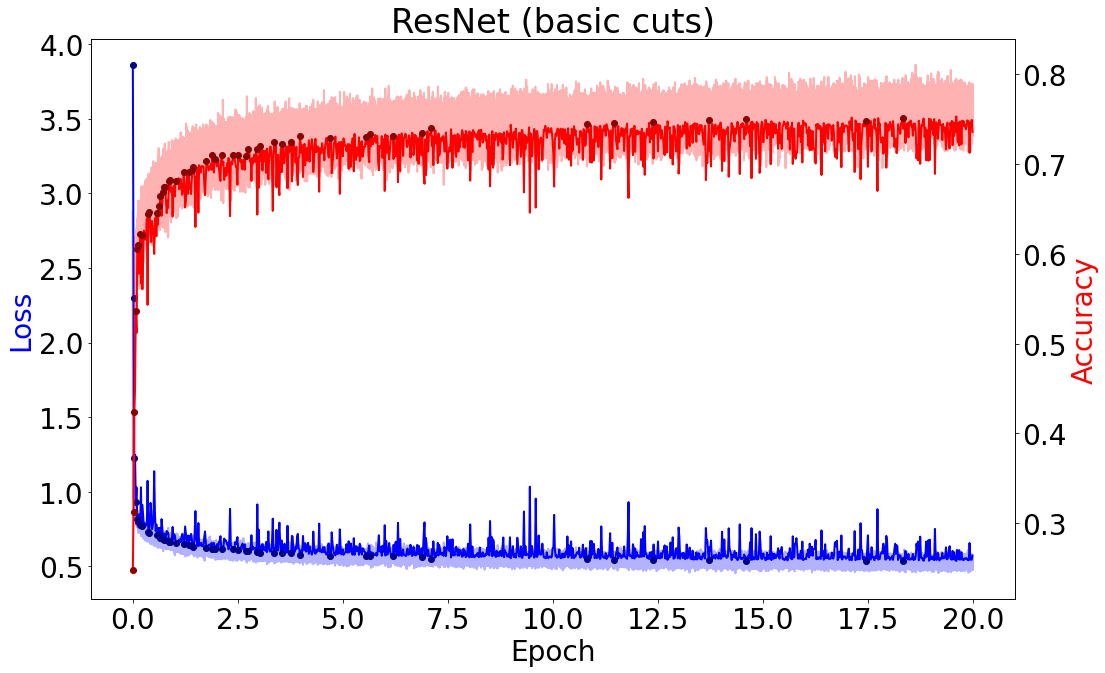

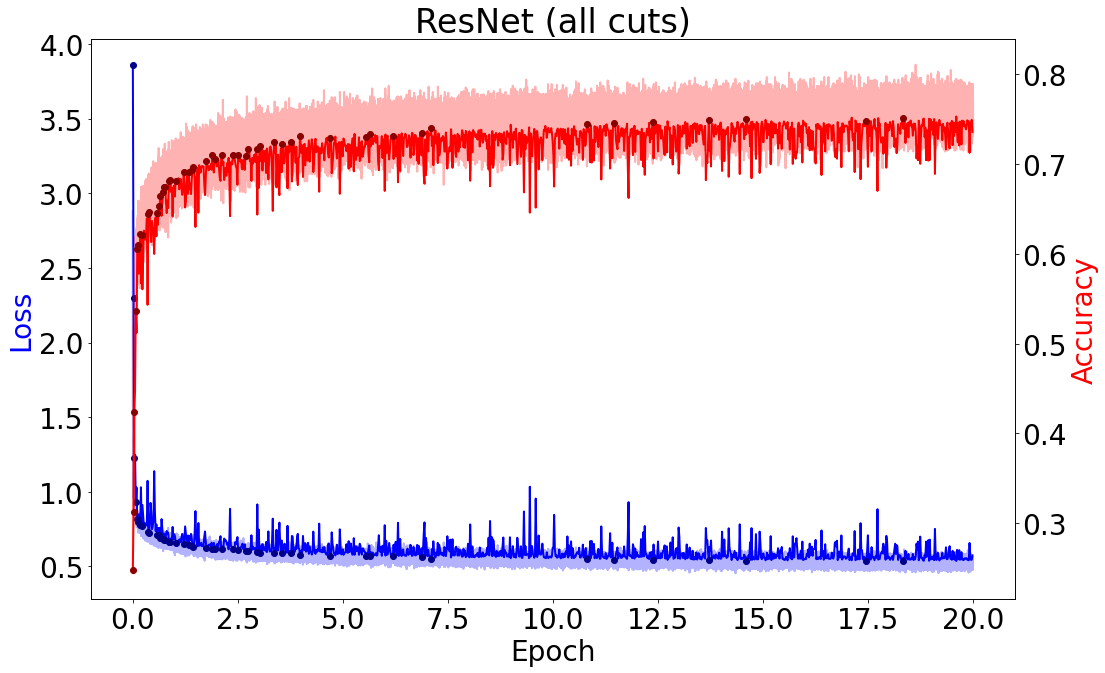

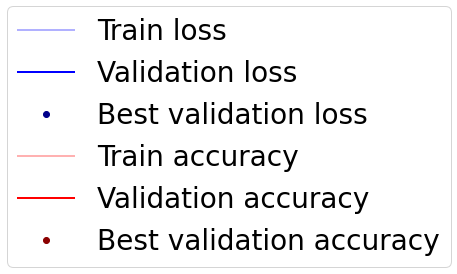

In [30]:
resnet_runs = pid_runs[:2] # first two are WatChMaL ResNet runs
for r in resnet_runs:
    fig, ax1, ax2, = r.plot_training_progression(legend=None, fig_size=(16,10), title=r.run_label)
leg_fig, leg_ax = plot_legend((ax1, ax2))

## Plot results

### ROC curve for electron signal vs muon rejection

In [31]:
e_labels = [0, 1]
mu_labels = [2]

The `plot_rocs` function allows plotting overlaid ROC curves for a chosen signal and background classification.

In [32]:
help(plot_rocs)

Help on function plot_rocs in module analysis.classification:

plot_rocs(runs, signal_labels, background_labels, selection=None, ax=None, fig_size=None, x_label='', y_label='', x_lim=None, y_lim=None, y_log=None, x_log=None, legend='best', mode='rejection', **plot_args)
    Plot overlaid ROC curves of results from a number of classification runs
    
    Parameters
    ----------
    runs: sequence of ClassificationRun
        Sequence of runs to plot
    signal_labels: int or sequence of ints
        Set of labels corresponding to signal classes. Can be either a single label or a sequence of labels.
    background_labels: int or sequence of ints
        Set of labels corresponding to background classes. Can be either a single label or a sequence of labels.
    selection: indexing expression, optional
        Selection of the discriminator values to be used (by default use each run's predefined selection, or all events
        if none is defined).
    ax: matplotlib.axes.Axes
        A

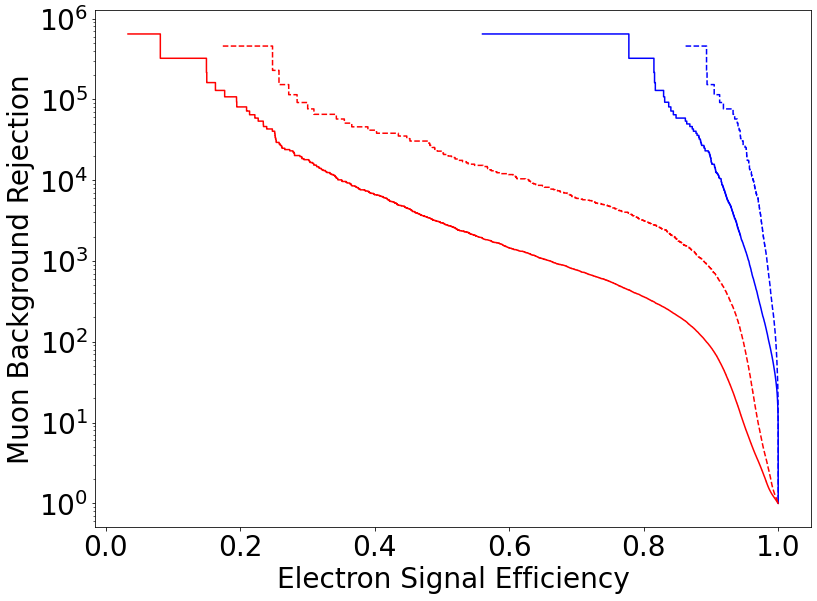

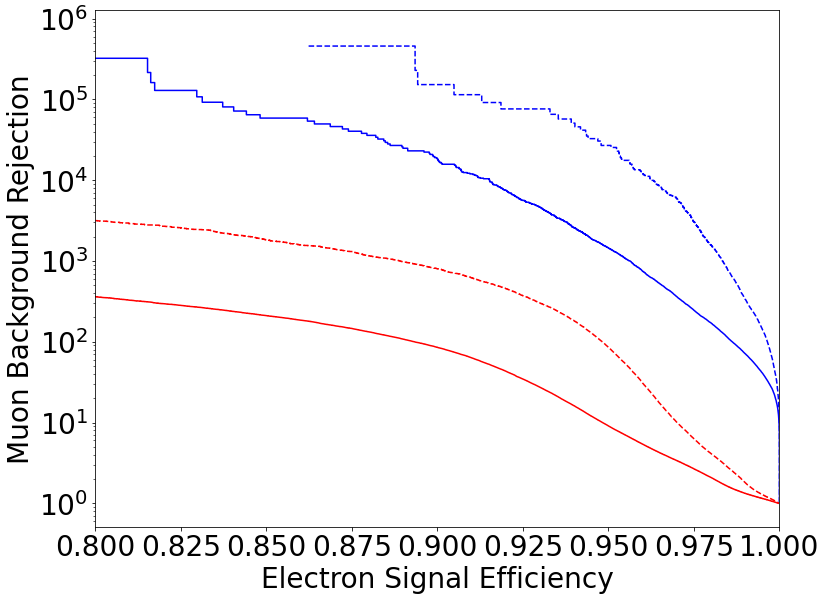

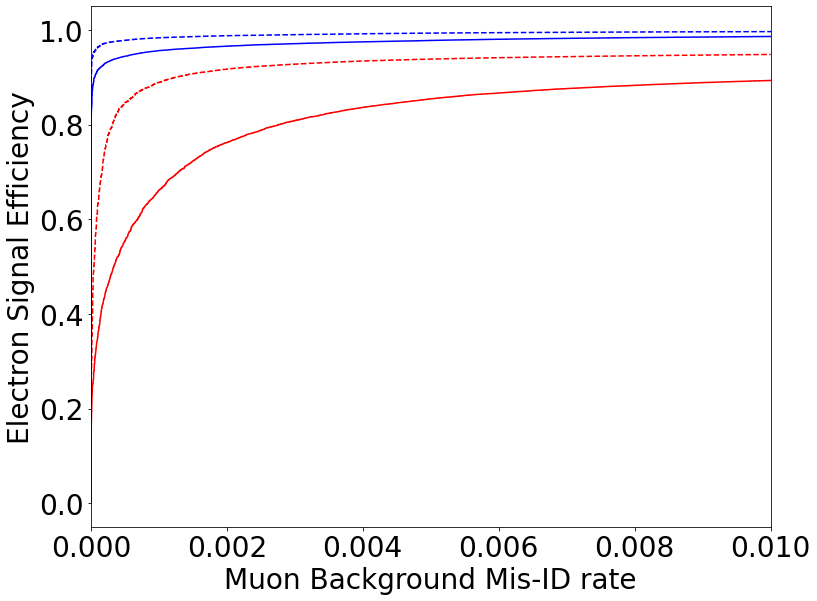

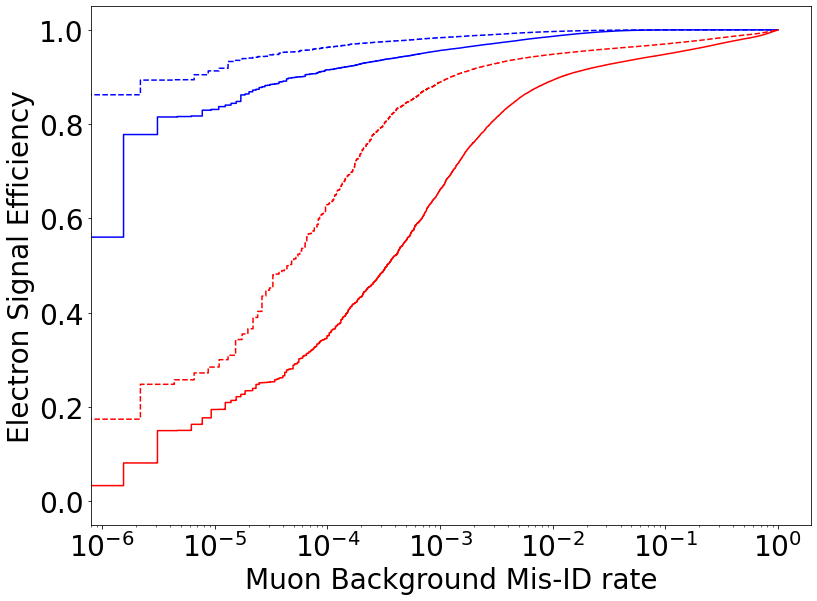

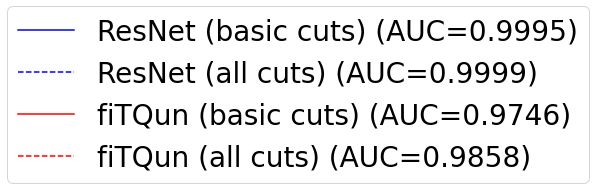

In [33]:
fig, ax = plot_rocs(pid_runs, e_labels, mu_labels, x_label="Electron Signal Efficiency", y_label="Muon Background Rejection", mode='rejection', legend=None)
fig, ax = plot_rocs(pid_runs, e_labels, mu_labels, x_label="Electron Signal Efficiency", y_label="Muon Background Rejection", mode='rejection', x_lim=(0.8,1), legend=None)
fig, ax = plot_rocs(pid_runs, e_labels, mu_labels, x_label="Muon Background Mis-ID rate", y_label="Electron Signal Efficiency", mode='efficiency', x_lim=(0,0.01), legend=None)
fig, ax = plot_rocs(pid_runs, e_labels, mu_labels, x_label="Muon Background Mis-ID rate", y_label="Electron Signal Efficiency", mode='efficiency', x_log=True, legend=None)
l_fig, l_ax = plot_legend(ax)

###  for fixed 0.1% muon mis-ID

### for each 50 MeV bin of reconstructed momentum, calculate the thresholds that reject 99.9% of muons and apply cut to all events

In [34]:
help(WatChMaLClassification.cut_with_fixed_efficiency)

Help on function cut_with_fixed_efficiency in module analysis.classification:

cut_with_fixed_efficiency(self, signal_labels, background_labels, efficiency, selection=None, select_labels=None, return_threshold=False)
    Generate array of boolean values indicating whether each event passes a cut defined such that a fixed proportion
    of the selected events pass the cut.
    After taking the subset of `discriminator_values` defined by `selection`, the threshold discriminator value is
    found such that the proportion that are above the threshold is equal to `efficiency`. This cut threshold is then
    used to apply the cut to all events (not just those selected by `selection`) and an array of booleans is
    returned for whether each discriminator value is above the threshold of its corresponding bin. The cut result is
    also stored for use in plotting efficiency profiles.
    
    Parameters
    ----------
    signal_labels: int or sequence of ints
        Set of labels correspond

In [35]:
muon_rejection = 0.999
muon_efficiency = 1-muon_rejection
for r in pid_runs:
    r.cut_with_fixed_efficiency(e_labels, mu_labels, muon_efficiency, select_labels=mu_labels)

### Plot signal efficiency against true momentum, dwall, towall, zenith, azimuth

In [36]:
help(plot_efficiency_profile)

Help on function plot_efficiency_profile in module analysis.classification:

plot_efficiency_profile(runs, binning, selection=None, select_labels=None, ax=None, fig_size=None, x_label='', y_label='', legend='best', y_lim=None, **plot_args)
    Plot binned efficiencies for a cut applied to a number of classification runs.
    Each run should already have had a cut generated, then in each bin the proportion of events passing the cut is
    calculated as the efficiency and plotted. A selection can be provided to use only a subset of all the values. The
    same binning and selection is applied to each run.
    
    Parameters
    ----------
    runs: sequence of ClassificationRun
        Sequence of runs to plot
    binning: (np.ndarray, np.ndarray)
        Array of bin edges and array of bin indices, returned from `analysis.utils.binning.get_binning`.
    selection: indexing expression, optional
        Selection of the values to use in calculating the efficiencies (by default use each r

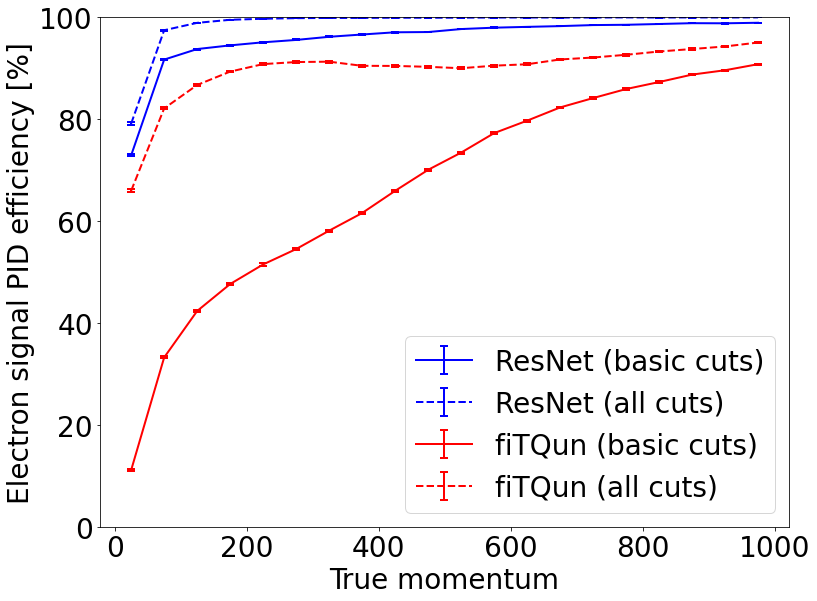

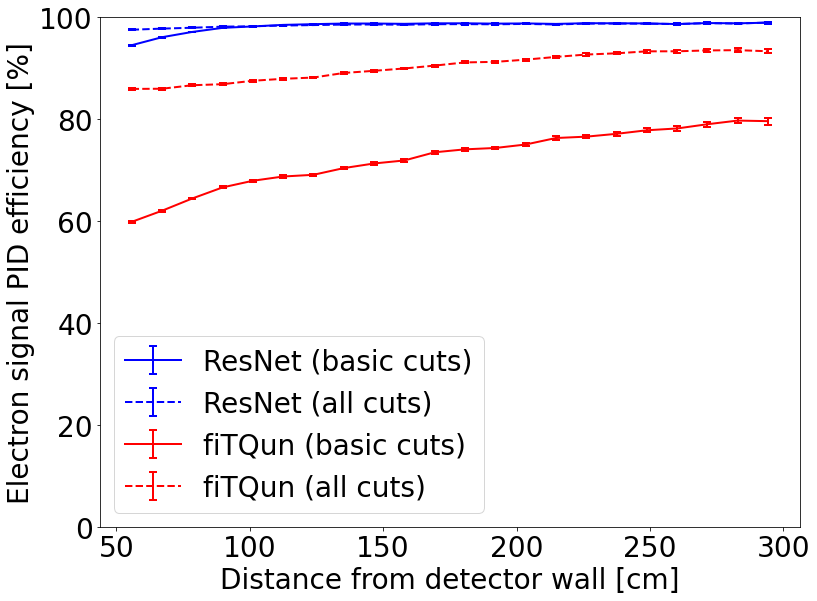

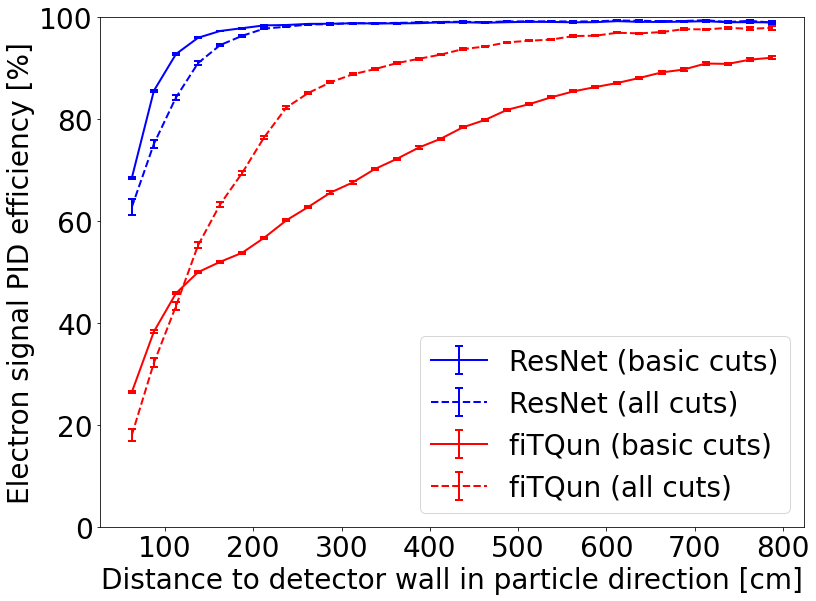

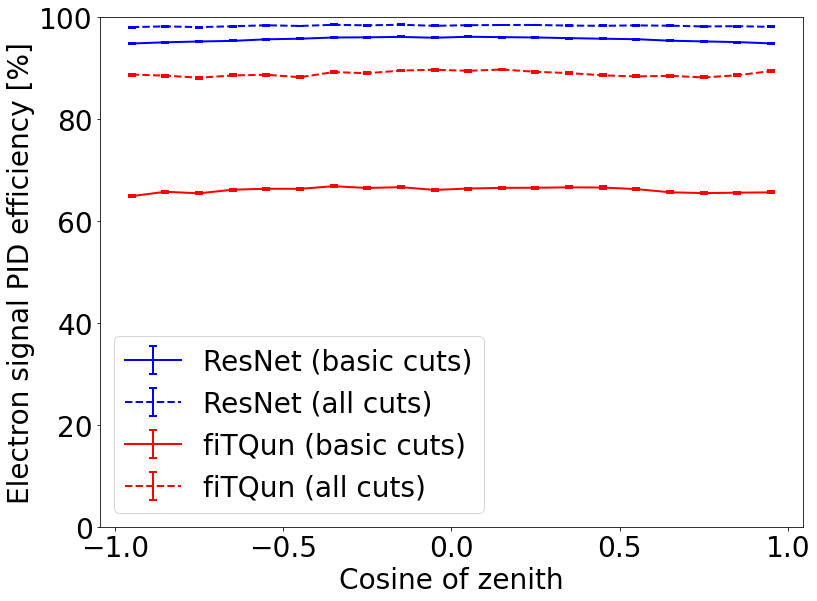

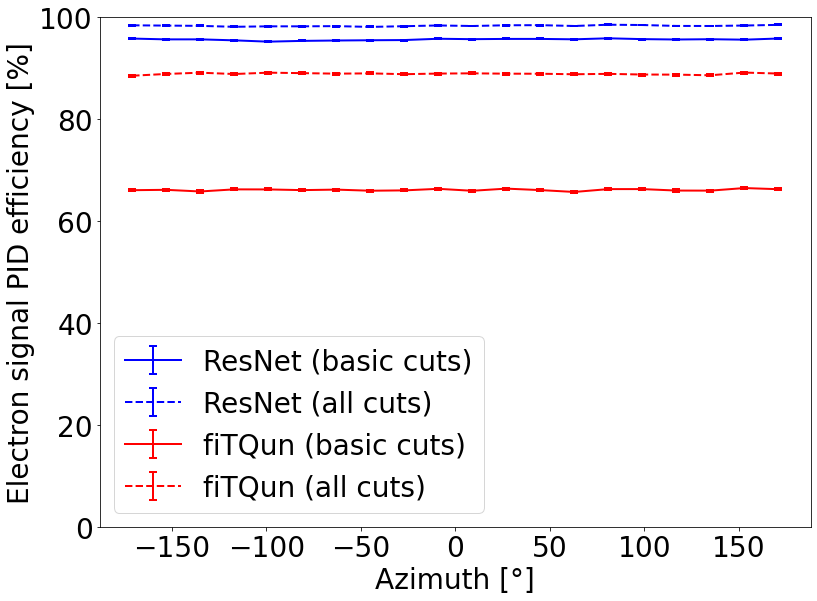

In [37]:
fig, ax = plot_efficiency_profile(pid_runs, mom_binning, select_labels=e_labels, x_label="True momentum", y_label="Electron signal PID efficiency [%]", errors=True, x_errors=False, y_lim=(0,100))
fig, ax = plot_efficiency_profile(pid_runs, dwall_binning, select_labels=e_labels, x_label="Distance from detector wall [cm]", y_label="Electron signal PID efficiency [%]", errors=True, x_errors=False, y_lim=(0,100))
fig, ax = plot_efficiency_profile(pid_runs, towall_binning, select_labels=e_labels, x_label="Distance to detector wall in particle direction [cm]", y_label="Electron signal PID efficiency [%]", errors=True, x_errors=False, y_lim=(0,100))
fig, ax = plot_efficiency_profile(pid_runs, cos_zenith_binning, select_labels=e_labels, x_label="Cosine of zenith", y_label="Electron signal PID efficiency [%]", errors=True, x_errors=False, y_lim=(0,100))
fig, ax = plot_efficiency_profile(pid_runs, azimuth_binning, select_labels=e_labels, x_label="Azimuth [°]", y_label="Electron signal PID efficiency [%]", errors=True, x_errors=False, y_lim=(0,100))

### Plot background mis-ID against true momentum, dwall, towall, zenith, azimuth

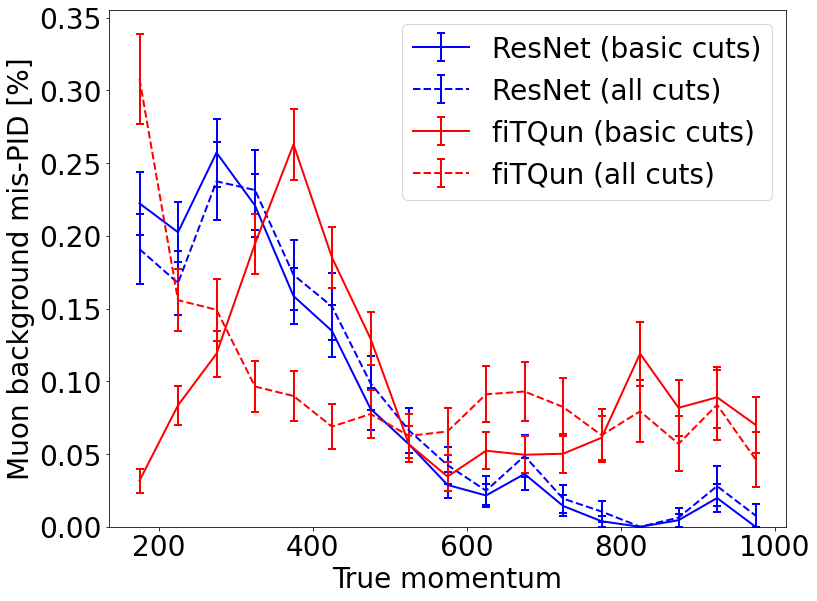

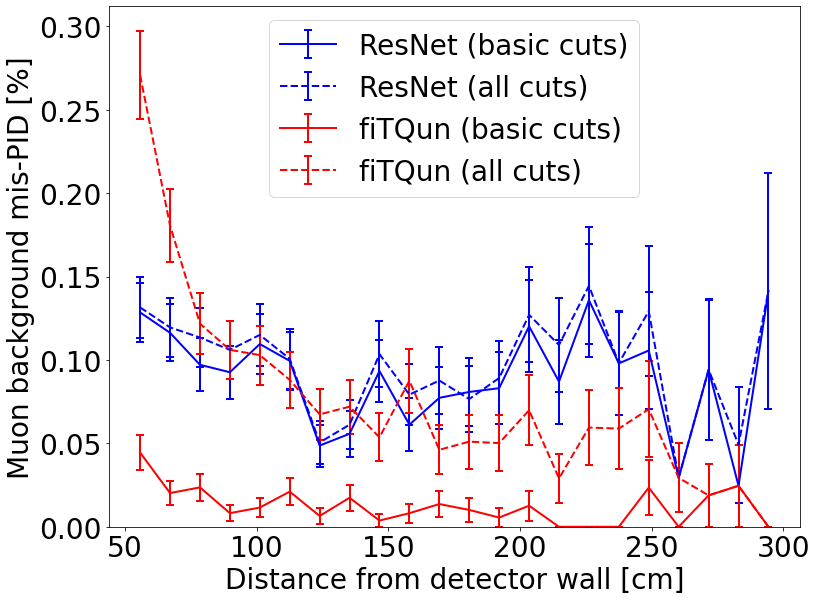

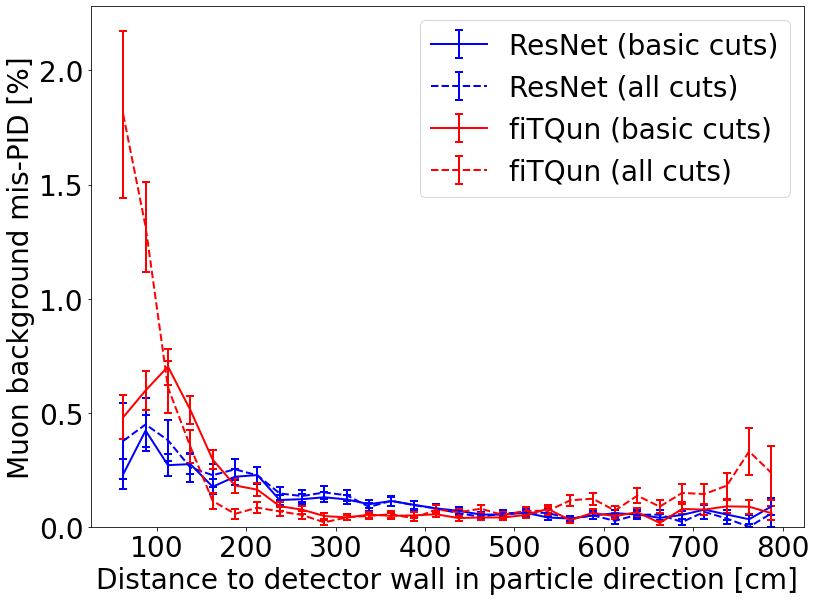

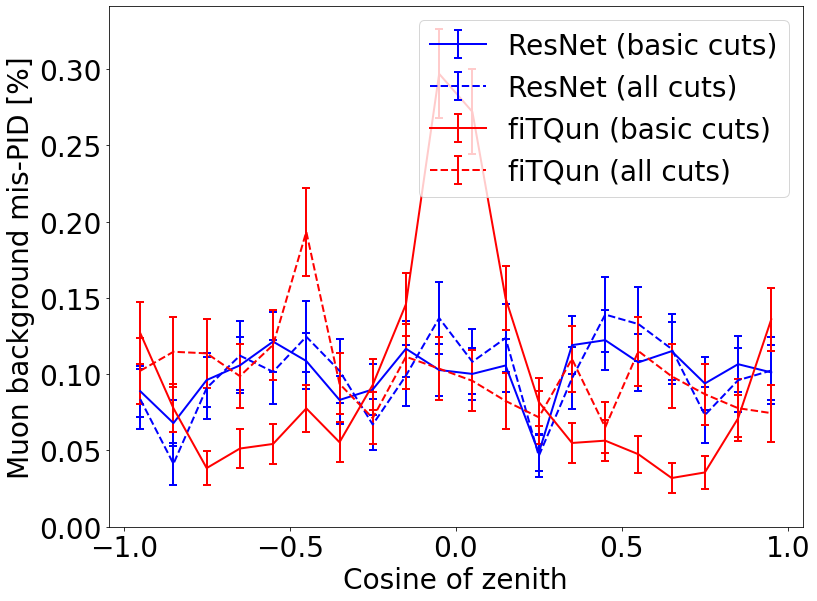

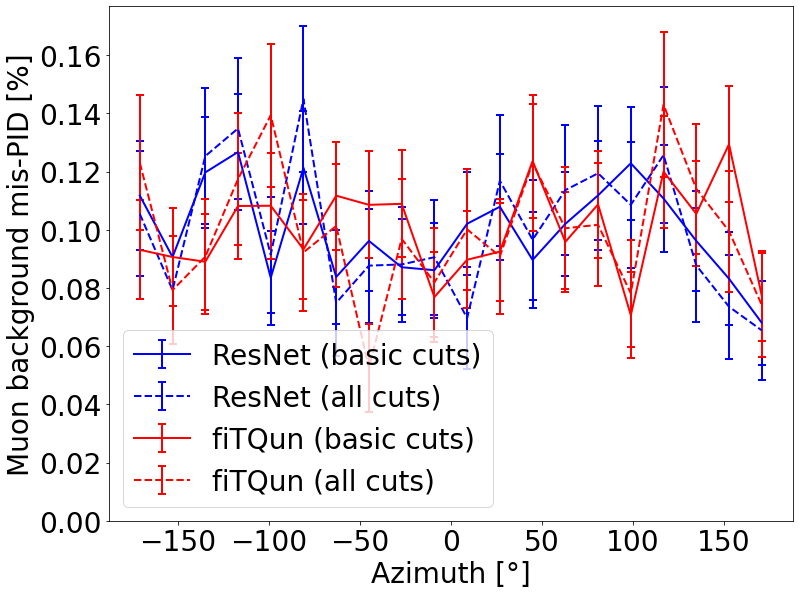

In [38]:
fig, ax = plot_efficiency_profile(pid_runs, mom_binning_mu, select_labels=mu_labels, x_label="True momentum", y_label="Muon background mis-PID [%]", errors=True, x_errors=False, y_lim=0)
fig, ax = plot_efficiency_profile(pid_runs, dwall_binning, select_labels=mu_labels, x_label="Distance from detector wall [cm]", y_label="Muon background mis-PID [%]", errors=True, x_errors=False, y_lim=0)
fig, ax = plot_efficiency_profile(pid_runs, towall_binning, select_labels=mu_labels, x_label="Distance to detector wall in particle direction [cm]", y_label="Muon background mis-PID [%]", errors=True, x_errors=False, y_lim=0)
fig, ax = plot_efficiency_profile(pid_runs, cos_zenith_binning, select_labels=mu_labels, x_label="Cosine of zenith", y_label="Muon background mis-PID [%]", errors=True, x_errors=False, y_lim=0)
fig, ax = plot_efficiency_profile(pid_runs, azimuth_binning, select_labels=mu_labels, x_label="Azimuth [°]", y_label="Muon background mis-PID [%]", errors=True, x_errors=False, y_lim=0)

# Electron vs gamma

## Load results
### Load ResNet and fiTQun results

In [39]:
pid_runs = [
    WatChMaLClassification("/home/lbidulka/WatChMaL/outputs/2022-07-06/07-47-10/", "ResNet (basic cuts)", h5_labels, test_idxs, eg_basic_cuts, color="blue", linestyle='-'),
    WatChMaLClassification("/home/lbidulka/WatChMaL/outputs/2022-07-06/07-47-10/", "ResNet (all cuts)", h5_labels, test_idxs, eg_all_cuts, color="blue", linestyle='--'),
    FiTQunClassification(fq, "fiTQun (basic cuts)", h5_labels, h5_fq_offsets, eg_basic_cuts, color='red', linestyle='-'),
    FiTQunClassification(fq, "fiTQun (all cuts)", h5_labels, h5_fq_offsets, eg_all_cuts, color='red', linestyle='--'),
]

## Plot results

### ROC curve for electron signal vs gamma rejection

In [40]:
e_label = [1]
g_label = [0]

/home/nprouse/WatChMaL/WatChMaL/analysis/classification.py:479: RuntimeWarning: invalid value encountered in true_divide
  return signal_softmax / (signal_softmax + background_softmax)
/home/nprouse/WatChMaL/WatChMaL/analysis/classification.py:479: RuntimeWarning: invalid value encountered in true_divide
  return signal_softmax / (signal_softmax + background_softmax)
/home/nprouse/WatChMaL/WatChMaL/analysis/classification.py:479: RuntimeWarning: invalid value encountered in true_divide
  return signal_softmax / (signal_softmax + background_softmax)
/home/nprouse/WatChMaL/WatChMaL/analysis/classification.py:479: RuntimeWarning: invalid value encountered in true_divide
  return signal_softmax / (signal_softmax + background_softmax)
/home/nprouse/WatChMaL/WatChMaL/analysis/classification.py:479: RuntimeWarning: invalid value encountered in true_divide
  return signal_softmax / (signal_softmax + background_softmax)
/home/nprouse/WatChMaL/WatChMaL/analysis/classification.py:479: RuntimeWarn

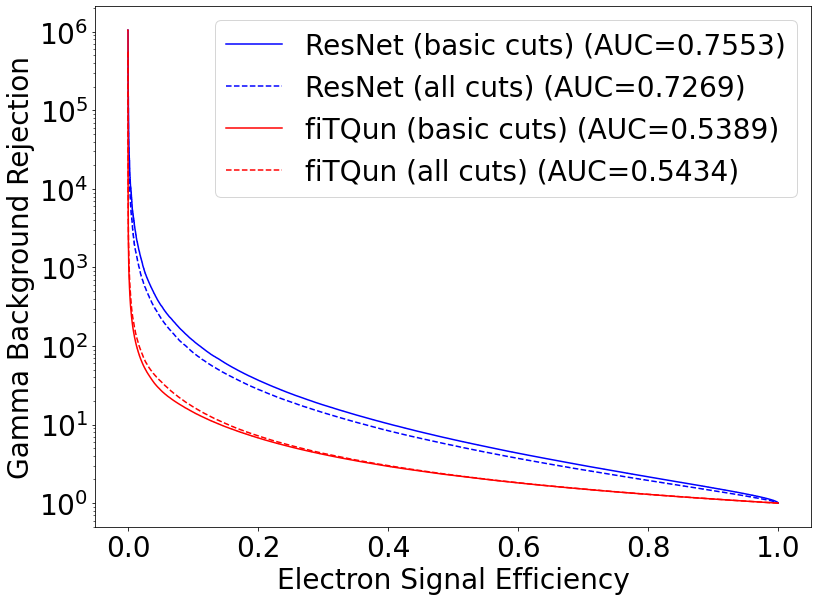

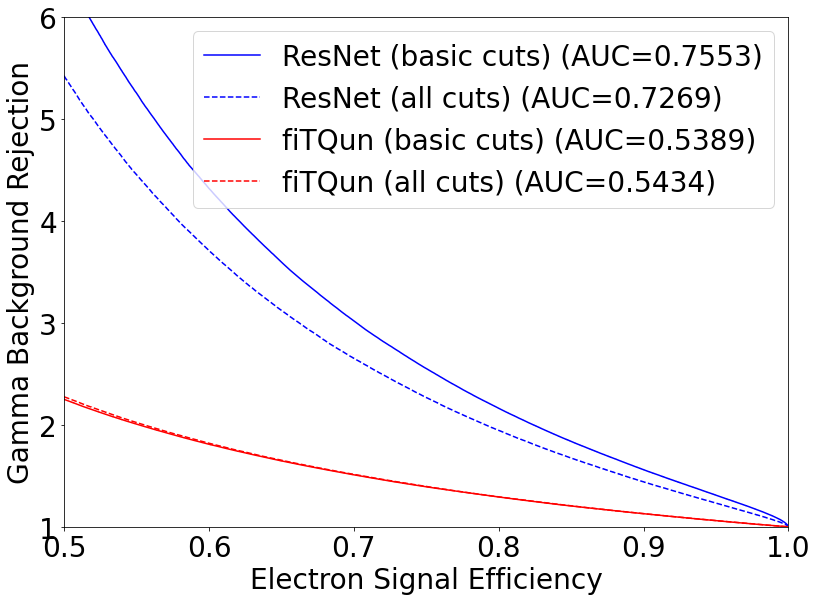

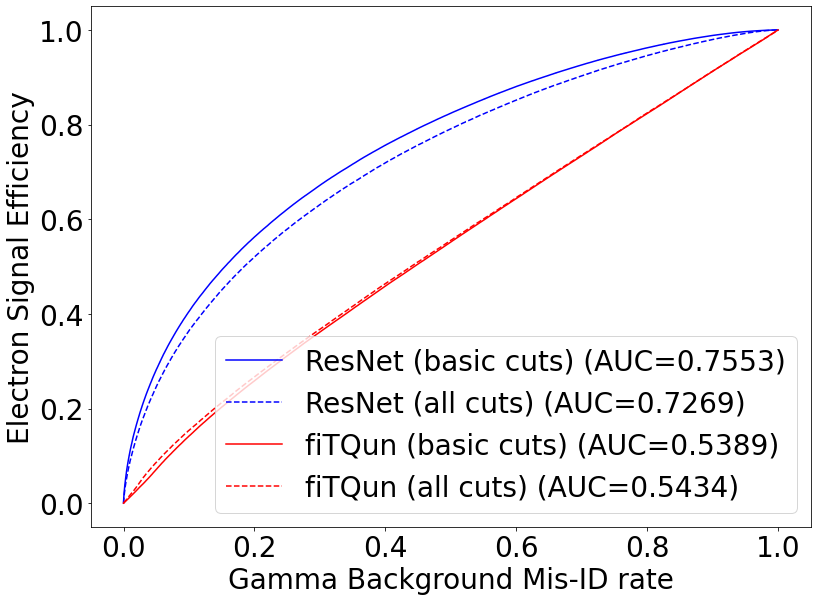

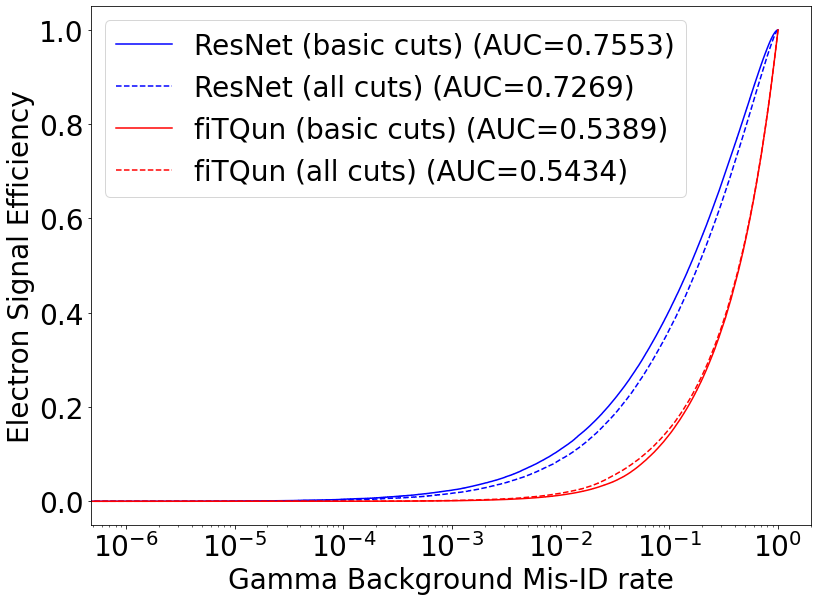

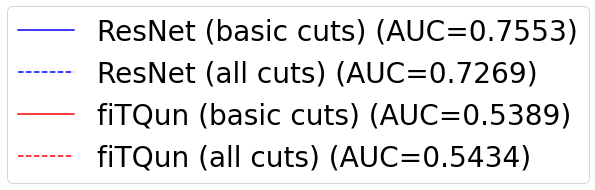

In [41]:
fig, ax = plot_rocs(pid_runs, e_label, g_label, x_label="Electron Signal Efficiency", y_label="Gamma Background Rejection", mode='rejection')
fig, ax = plot_rocs(pid_runs, e_label, g_label, x_label="Electron Signal Efficiency", y_label="Gamma Background Rejection", mode='rejection', x_lim=(0.5,1), y_log=False, y_lim=(1,6))
fig, ax = plot_rocs(pid_runs, e_label, g_label, x_label="Gamma Background Mis-ID rate", y_label="Electron Signal Efficiency", mode='efficiency')
fig, ax = plot_rocs(pid_runs, e_label, g_label, x_label="Gamma Background Mis-ID rate", y_label="Electron Signal Efficiency", mode='efficiency', x_log=True)
l_fig, l_ax = plot_legend(ax)

### ROC curve for gamma signal vs electron rejection

/home/nprouse/WatChMaL/WatChMaL/analysis/classification.py:479: RuntimeWarning: invalid value encountered in true_divide
  return signal_softmax / (signal_softmax + background_softmax)
/home/nprouse/WatChMaL/WatChMaL/analysis/classification.py:479: RuntimeWarning: invalid value encountered in true_divide
  return signal_softmax / (signal_softmax + background_softmax)
/home/nprouse/WatChMaL/WatChMaL/analysis/classification.py:479: RuntimeWarning: invalid value encountered in true_divide
  return signal_softmax / (signal_softmax + background_softmax)
/home/nprouse/WatChMaL/WatChMaL/analysis/classification.py:479: RuntimeWarning: invalid value encountered in true_divide
  return signal_softmax / (signal_softmax + background_softmax)
/home/nprouse/WatChMaL/WatChMaL/analysis/classification.py:479: RuntimeWarning: invalid value encountered in true_divide
  return signal_softmax / (signal_softmax + background_softmax)
/home/nprouse/WatChMaL/WatChMaL/analysis/classification.py:479: RuntimeWarn

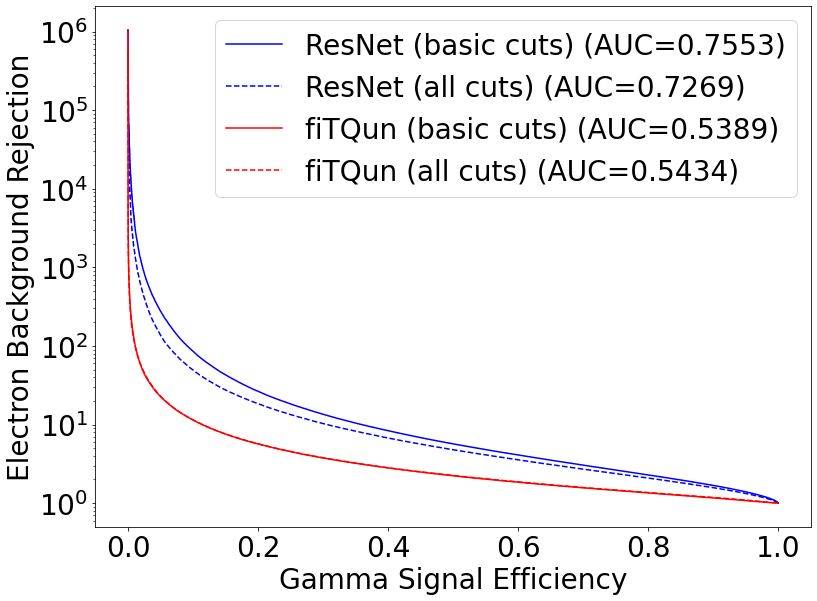

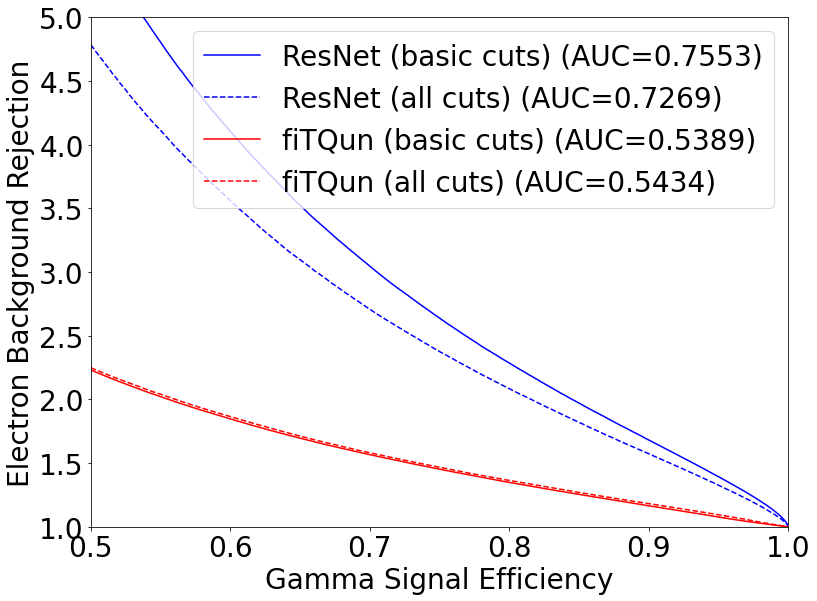

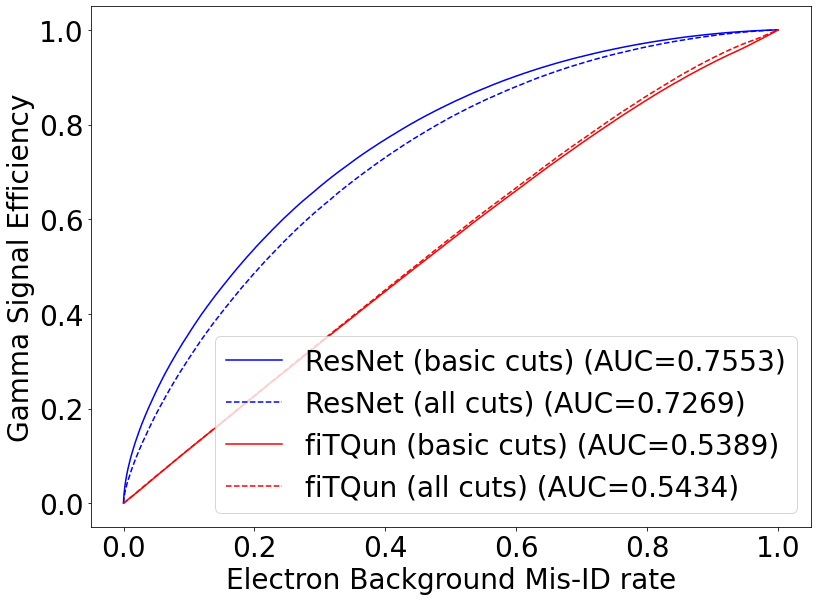

In [42]:
fig, ax = plot_rocs(pid_runs, g_label, e_label, x_label="Gamma Signal Efficiency", y_label="Electron Background Rejection", mode='rejection')
fig, ax = plot_rocs(pid_runs, g_label, e_label, x_label="Gamma Signal Efficiency", y_label="Electron Background Rejection", mode='rejection', x_lim=(0.5,1), y_log=False, y_lim=(1,5))
fig, ax = plot_rocs(pid_runs, g_label, e_label, x_label="Electron Background Mis-ID rate", y_label="Gamma Signal Efficiency", mode='efficiency')

###  for fixed 20% gamma mis-ID

### for each 50 MeV bin of reconstructed momentum, calculate the thresholds that reject 99.9% of muons and apply cut to all events

In [43]:
gamma_rejection = 0.8
gamma_efficiency = 1-gamma_rejection
for r in pid_runs:
    r.cut_with_fixed_efficiency(e_label, g_label, gamma_efficiency, select_labels=g_label)

/home/nprouse/WatChMaL/WatChMaL/analysis/classification.py:479: RuntimeWarning: invalid value encountered in true_divide
  return signal_softmax / (signal_softmax + background_softmax)


### Plot signal efficiency against true momentum, dwall, towall, zenith, azimuth

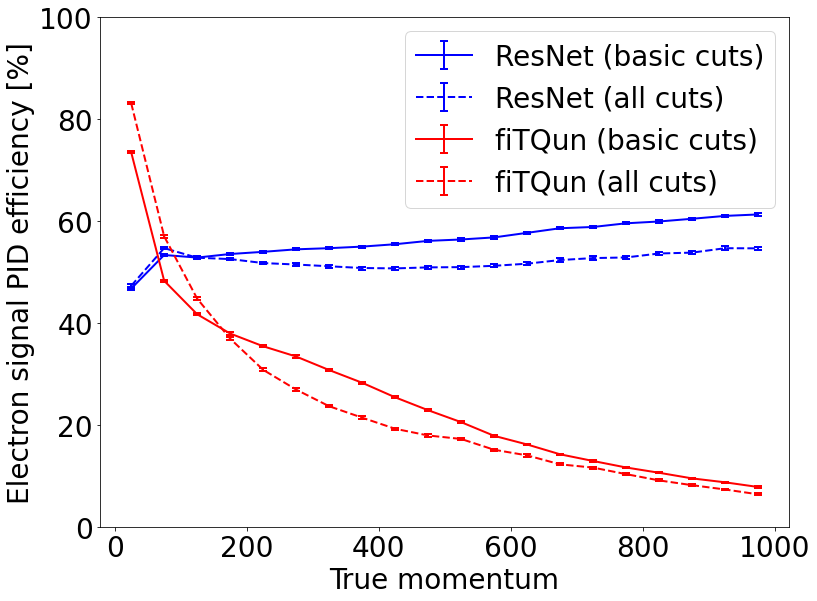

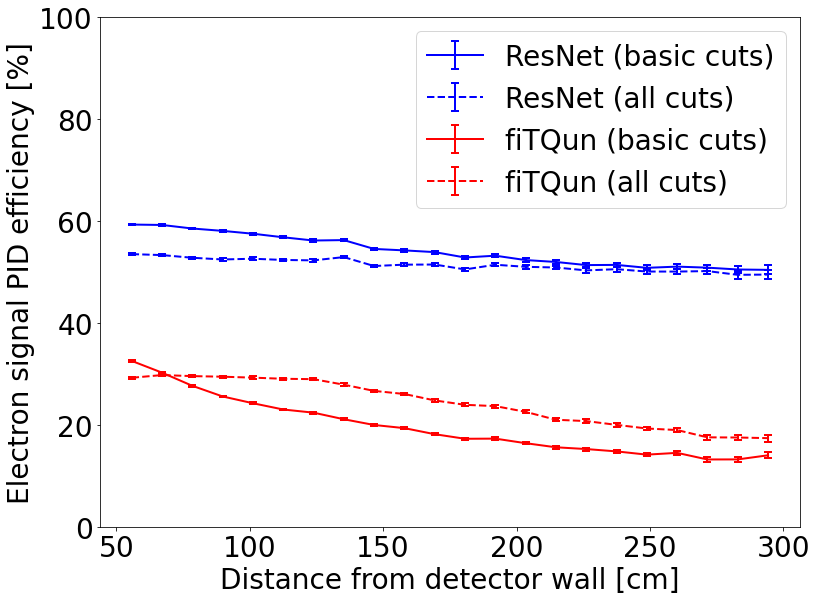

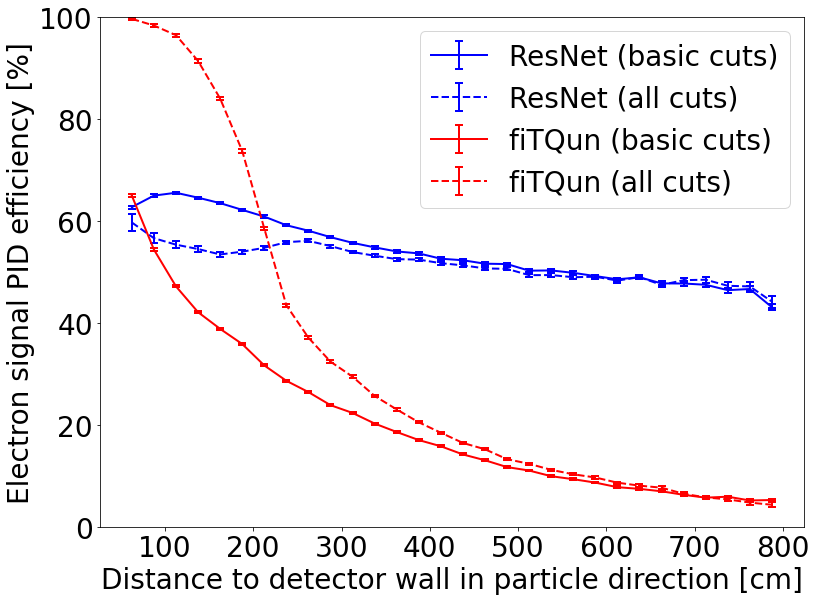

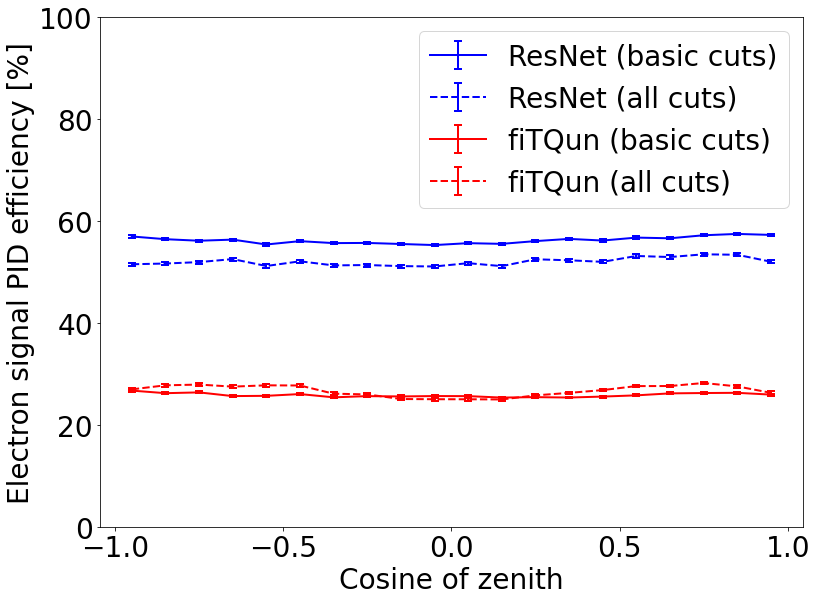

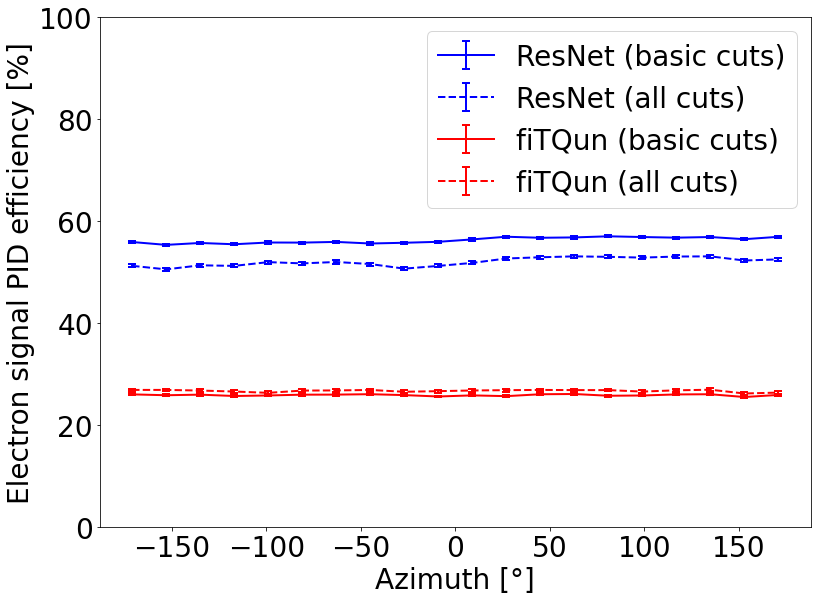

In [44]:
fig, ax = plot_efficiency_profile(pid_runs, mom_binning, select_labels=e_label, x_label="True momentum", y_label="Electron signal PID efficiency [%]", errors=True, x_errors=False, y_lim=(0,100))
fig, ax = plot_efficiency_profile(pid_runs, dwall_binning, select_labels=e_label, x_label="Distance from detector wall [cm]", y_label="Electron signal PID efficiency [%]", errors=True, x_errors=False, y_lim=(0,100))
fig, ax = plot_efficiency_profile(pid_runs, towall_binning, select_labels=e_label, x_label="Distance to detector wall in particle direction [cm]", y_label="Electron signal PID efficiency [%]", errors=True, x_errors=False, y_lim=(0,100))
fig, ax = plot_efficiency_profile(pid_runs, cos_zenith_binning, select_labels=e_label, x_label="Cosine of zenith", y_label="Electron signal PID efficiency [%]", errors=True, x_errors=False, y_lim=(0,100))
fig, ax = plot_efficiency_profile(pid_runs, azimuth_binning, select_labels=e_label, x_label="Azimuth [°]", y_label="Electron signal PID efficiency [%]", errors=True, x_errors=False, y_lim=(0,100))

### Plot background mis-ID against true momentum, dwall, towall, zenith, azimuth

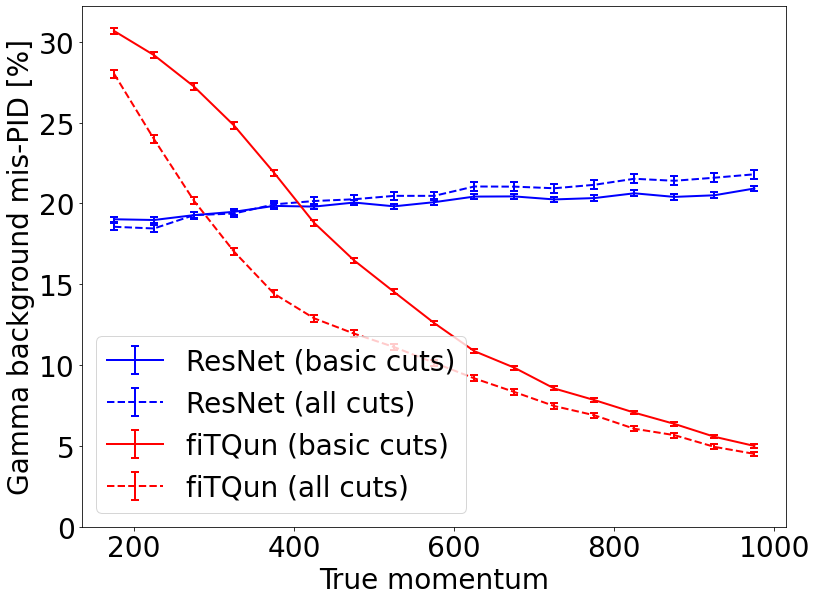

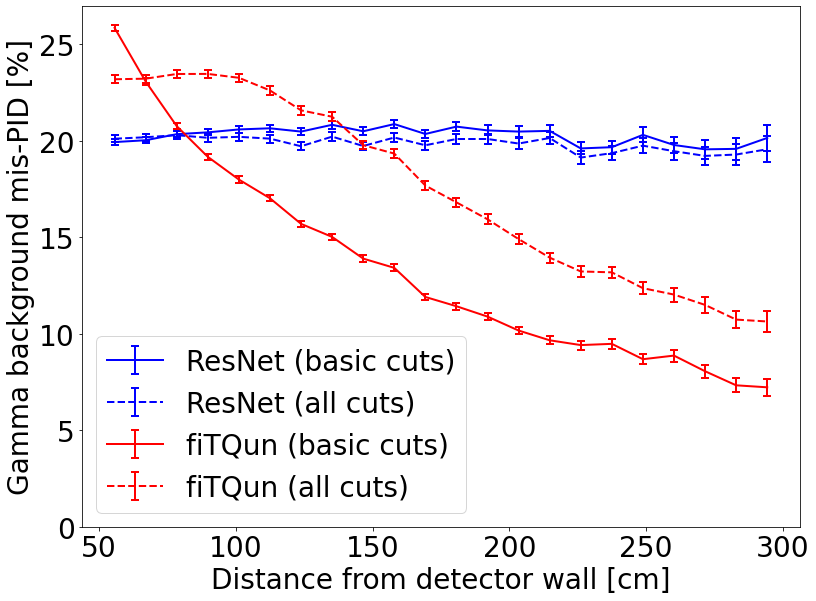

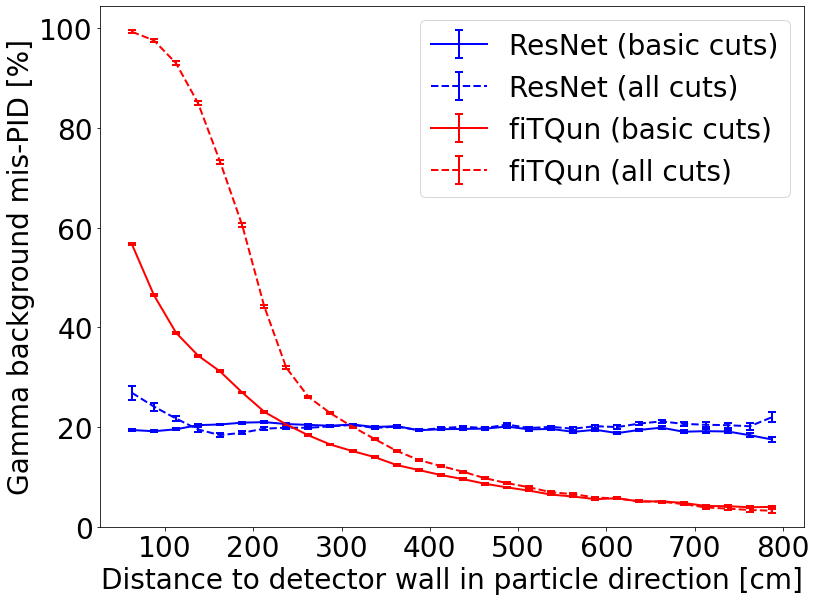

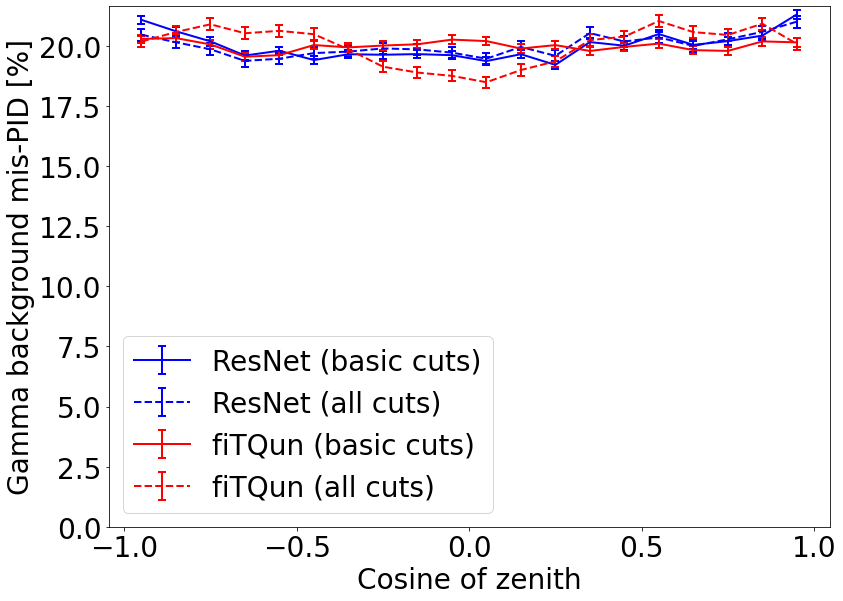

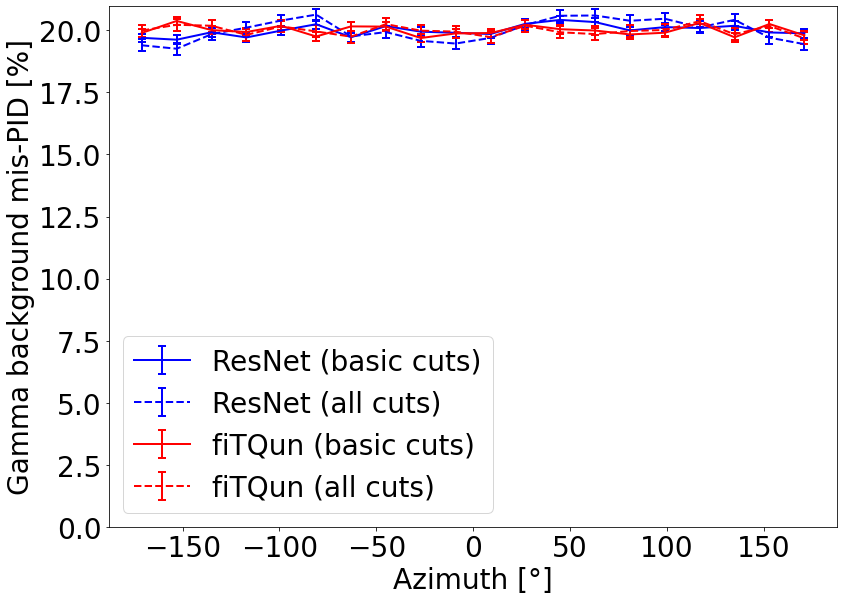

In [45]:
fig, ax = plot_efficiency_profile(pid_runs, mom_binning_mu, select_labels=g_label, x_label="True momentum", y_label="Gamma background mis-PID [%]", errors=True, x_errors=False, y_lim=0)
fig, ax = plot_efficiency_profile(pid_runs, dwall_binning, select_labels=g_label, x_label="Distance from detector wall [cm]", y_label="Gamma background mis-PID [%]", errors=True, x_errors=False, y_lim=0)
fig, ax = plot_efficiency_profile(pid_runs, towall_binning, select_labels=g_label, x_label="Distance to detector wall in particle direction [cm]", y_label="Gamma background mis-PID [%]", errors=True, x_errors=False, y_lim=0)
fig, ax = plot_efficiency_profile(pid_runs, cos_zenith_binning, select_labels=g_label, x_label="Cosine of zenith", y_label="Gamma background mis-PID [%]", errors=True, x_errors=False, y_lim=0)
fig, ax = plot_efficiency_profile(pid_runs, azimuth_binning, select_labels=g_label, x_label="Azimuth [°]", y_label="Gamma background mis-PID [%]", errors=True, x_errors=False, y_lim=0)